# How do neural networks relate to linear regression? 
*Where we show that neural networks provide a generalisation of other statistical methods*

When I first started to learn statistics in university, all methods seemed to be separate from each other. We used linear regression to predict the amount of soil erosion on a given hill slope, and [kriging](https://en.wikipedia.org/wiki/Kriging) to spatially interpolate radiation values. However, after some time I realized that kriging is just a special form of linear regression where the observations are spatially correlated to each other. This has consistently been my experience: statistical concepts and methods are much more related to each other than they would appear at first glance. 

But how is this the case for linear regression and neural networks? Surely a neural network is something completely different from simple basic linear regression? In this article we explore the relationship between these two methods using a concrete example, and what this says about the nature of neural networks. In addition, we will go into some practical advice on when to pick regular statistical methods over neural networks. 

# Fuel efficieny models
In this example we will build two regression models that predict fuel efficiency based on the weight of the car, based on the classic `mtcars` dataset. One will be using on lineair regression from the `stasmodels` package, the other will use `keras` to build a neural network. The goal of this section is to show that they represent the **exact same** model using the exact same `y = ax + b` formulation. 

After loading the data we can clearly see the relationship between weight and fuel efficiency: 

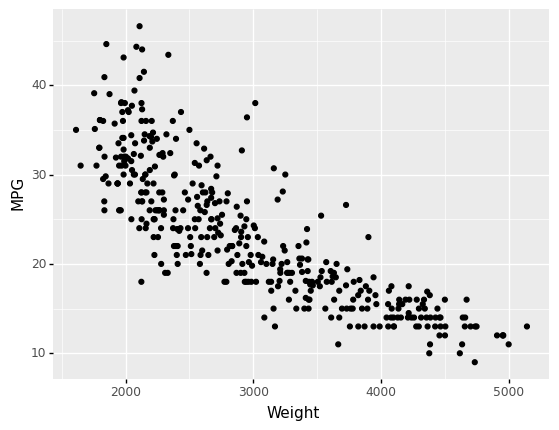

<ggplot: (8787901752061)>

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from plotnine import *

mtcars = pd.read_csv('mtcars.csv')
(
    ggplot(mtcars) + geom_point(aes(x='Weight', y='MPG'))
)

a lighter car can drive more miles-per-gallon on the same gallon of fuel. This makes sense as the car does not have to drag along all the addition weight. 

First we need to normalize the data, without it Keras has a hard time fitting a good model:

In [8]:
from tensorflow.keras.layers import Normalization

# This needs to be added in front, or the solution will be very unstable
normalizer = Normalization(input_shape=[1,], axis=None)
normalizer.adapt(mtcars['Weight'])

mtcars['Weight_norm'] = np.array(normalizer(mtcars['Weight'])).flatten()

Next we split the data into a training set and a test set:

In [9]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(mtcars, test_size=0.1)

With the data ready, we can build both models. We first start with the linear regression

In [10]:
# KERAS MODEL ---------------
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense

keras_mpg_weight = Sequential([ 
    Input(shape=(1,)), 
    Dense(units=1)
])

keras_mpg_weight.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mean_squared_error')

history = keras_mpg_weight.fit(
    train_data['Weight_norm'], train_data['MPG'],
    epochs=100, verbose=0, validation_split = 0.2)

# STATSMODEL OLS ---------------
from statsmodels.formula.api import ols

train_data['Weight_norm'] = np.array(normalizer([train_data['Weight']])).flatten()
ols_mpg_weight = ols("MPG ~ Weight_norm", data=train_data).fit()

Looking at the fitted coefficients of both the regression and keras model we can see that they are roughly the same with an intercept of around -6.5 and a slope of 23.5. 

In [11]:
print(keras_mpg_weight.get_weights())
print(ols_mpg_weight.params)

[array([[-6.629105]], dtype=float32), array([23.514563], dtype=float32)]
Intercept      23.444660
Weight_norm    -6.511469
dtype: float64


If we plot the residuals of both models, we confirm that the models are very very similar:

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: residualplot.png


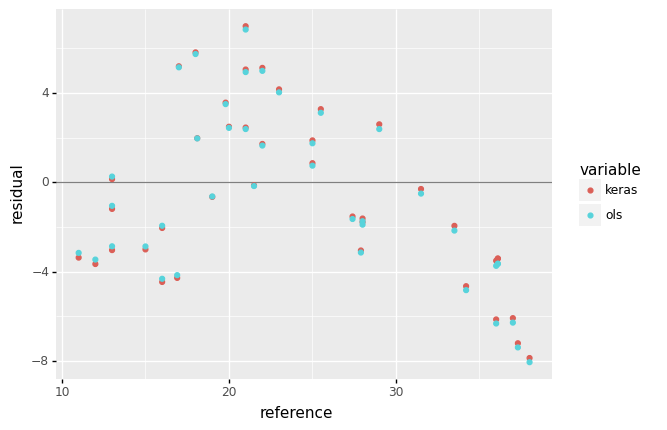

<ggplot: (8787901881254)>

In [14]:
from plotnine import *

prediction_results = pd.DataFrame({'keras'     : keras_mpg_weight.predict(test_data['Weight_norm']).flatten(),
                                   'ols'       : ols_mpg_weight.predict(test_data['Weight_norm']),
                                   'reference' : test_data['MPG']})

plot_data = (
    prediction_results
      .melt(id_vars='reference')
      .assign(residual = lambda x: x['value'] - x['reference'])
)

gg = (
    ggplot(plot_data) 
      + geom_hline(aes(yintercept = 0), alpha = 0.5)
      + geom_point(aes(x='reference', y='residual', color='variable')) 
)

ggsave(gg, 'residualplot.png', dpi=200)
gg

# Neural networks as a generalisation
- As we saw, we can formulate the exact linear regression model as a neural network
- This holds for more methods:
   - PCA
   - Tsfresh + regression
   
# But what is the trade-off?
De generieke aard van NN heeft als voordeel dat je vrijwel elke functie kunt nabouwen. Je hoeft dus niet met de hand je probleem goed te defnieren op het te kunnen oplossen. Maar het ontdekken van de verborgen functie betekent wel dat je veel data en tijd nodig hebt om deze functie te ontdekken. Je moet steeds meer coefs bepalen:
	- OLS, orde grootte 10 coef, geen optim doordat je een wiskundige definitie hebt van de OLS coefs
	- Tsfresh/Lasso, 100-500 coef, optim opzoeken!
Neural netwerk, 10e3 - 10e9 coefs, optim via stochastic gradient descent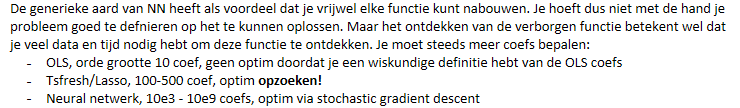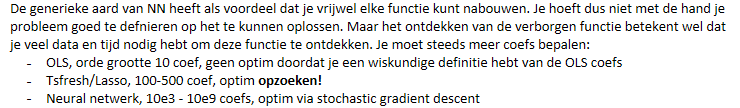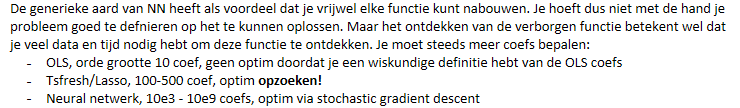

# Practical advice: when to do what